# gpvolve

Current functionality in `gpvolve.markov` and `gpvolve.simulate`. 

In [22]:
import gpmap
import gpvolve
from scipy.sparse import dok_matrix
%matplotlib inline
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

#### Generate a rough mount fuji map with 5 sites that can each have 2 states

In [24]:
gpm = gpmap.simulate.generate_gpm(alphabet='01', num_sites=5, num_states_per_site=2)

# generate fuji fitness landscape towards derived state
gpm.data.loc[:, 'fitness'] = gpmap.simulate.fuji(gpm, ref_genotype = '1'*5, roughness = 0)
gpm.data.loc[gpm.data.fitness < 0,"fitness"] = 0.0
gpm.get_neighbors()

#### Plot map

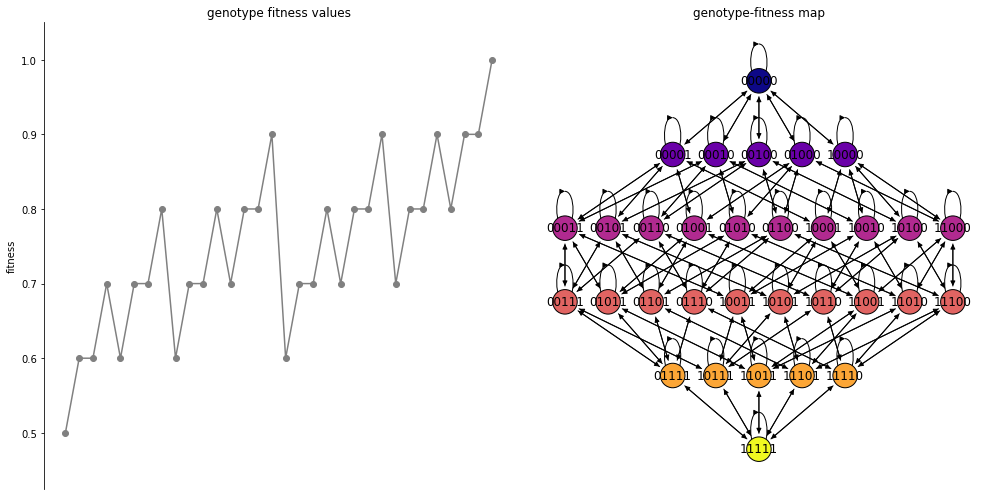

In [25]:
G = gpmap.GenotypePhenotypeGraph()
G.add_gpm(gpm)
G.add_node_cmap(data_column="fitness")
G.add_node_labels(data_column="binary")
G.edge_options["arrows"] = True
G.node_options["node_size"] = 600

fig, ax = plt.subplots(1,2,figsize=(14,7))

s = np.array([f"{b}" for b in gpm.data.binary])

ax[0].plot(gpm.fitness,color="gray")
ax[0].plot(gpm.fitness,"o",color="gray")
for i in range(len(gpm.data)):
    y_pos = np.min(gpm.fitness) - 0.1*np.abs(np.min(gpm.fitness))
    #ax[0].text(i,y_pos,gpm.data.binary.iloc[i],rotation="vertical")
    
ax[0].set_ylim(np.min(gpm.fitness)-0.15*np.abs(np.min(gpm.fitness)),np.max(gpm.fitness)*1.05)

_ = gpmap.plot(G,ax=ax[1],plot_node_labels=True)

for i in range(2):
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['left'].set_visible(False)
    ax[i].spines['bottom'].set_visible(False)

ax[0].spines["left"].set_visible(True)
ax[0].set_ylabel("fitness")
ax[0].xaxis.set_visible(False) 

ax[0].set_title("genotype fitness values")
ax[1].set_title("genotype-fitness map")

    
fig.tight_layout()

#### Calculating stochastic transition matrices

These give the relative probability that genotype $i$ transitions to its neighboring gentoypes. Each row sums to one and can include a substantial probability that genotype $i$ does not transition at all. 

In [26]:
# To calculate T, first get c-friendly representation of neigbors
neighbor_slicer,neighbors = gpvolve.utils.flatten_neighbors(gpm)

# Then calcualte transition matrix given fitness in gpm, neighbors, a fixation model, and a population size
# (fixation_model can be moran, mcclandish, or sswm (strong-selection, weak mutation)). 
T = gpvolve.markov.utils.generate_tmatrix(gpm.fitness,neighbor_slicer,neighbors,
                                          fixation_model="moran",
                                          population_size=10)

print("T is a row-stochastic matrix")
print("T dimensions:",T.shape)
print("column sums:",np.sum(T,axis=0))
print("row sums:",np.sum(T,axis=1))

T is a row-stochastic matrix
T dimensions: (32, 32)
column sums: [0.83975379 0.92295132 0.92295132 0.98337387 0.92295132 0.98337387
 0.98337387 1.02920273 0.92295132 0.98337387 0.98337387 1.02920273
 0.98337387 1.02920273 1.02920273 1.06513437 0.92295132 0.98337387
 0.98337387 1.02920273 0.98337387 1.02920273 1.02920273 1.06513437
 0.98337387 1.02920273 1.02920273 1.06513437 1.02920273 1.06513437
 1.06513437 1.09405178]
row sums: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1.]


In [27]:
print(T.diagonal())

[0.80123104 0.84688299 0.84688299 0.88006839 0.84688299 0.88006839
 0.88006839 0.90517967 0.84688299 0.88006839 0.88006839 0.90517967
 0.88006839 0.90517967 0.90517967 0.92479578 0.84688299 0.88006839
 0.88006839 0.90517967 0.88006839 0.90517967 0.90517967 0.92479578
 0.88006839 0.90517967 0.90517967 0.92479578 0.90517967 0.92479578
 0.92479578 0.94051779]


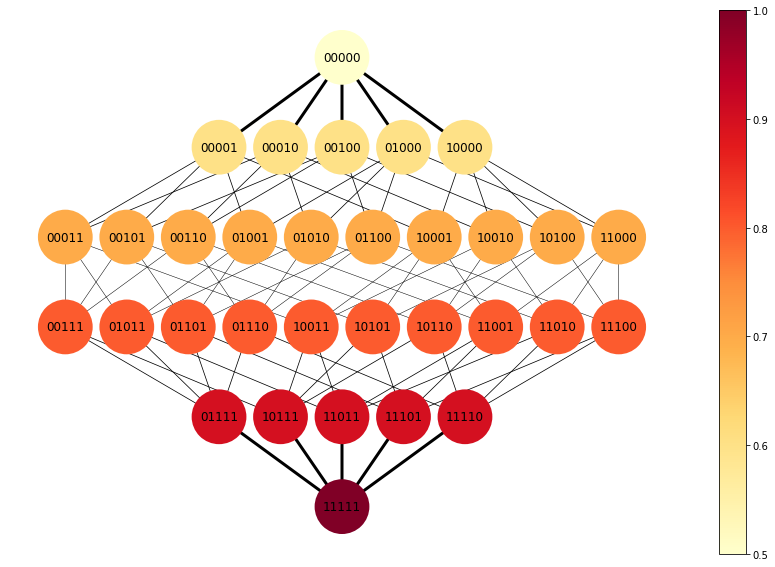

In [28]:
g = gpvolve.markovmodel.GenotypePhenotypeMSM(gpm)
g.transition_matrix = T
flux = gpvolve.flux.TransitionPathTheory(g, [0], [31])
norm_flux = flux.net_flux/flux.total_flux
fig, ax = gpvolve.pyplot.visualization.plot_network(g,
                       flux=dok_matrix(norm_flux), attribute='fitness',
                       colorbar=True, arrows=True)

In [32]:
from scipy.stats import entropy
# sum path probs across TPT edges
scs = list(gpm.neighbors[gpm.neighbors.direction == 1].source)
tgs = list(gpm.neighbors[gpm.neighbors.direction == 1].target)
pprob = []
for i in range(len(scs)):
    s = scs[i]
    t = tgs[i]
    pprob.append(norm_flux[s, t])
entropy(pprob)

4.131745463161852

In [27]:
edge_scalar=15.0
edgelist = flux.keys()
width = [edge_scalar * flx for flx in flux.values()]
gpm.neighbors['weight'] = width

G=gpmap.GenotypePhenotypeGraph()
G.add_gpm(gpm)
mask = gpm.neighbors.direction != 1
gpm.neighbors.loc[mask,"include"] = False

norm = mpl.colors.Normalize(vmin=min(gpm.data.phenotype), vmax=max(gpm.data.phenotype))

#gpm.data.loc[0, 'phenotype'] = min(gpm.data.loc[:, 'phenotype'])
#gpm.data.loc[len(gpm.data)-1, 'phenotype'] = max(gpm.data.loc[:, 'phenotype'])

#nodes = [0, .5, 1]
#colors = [[0,.6,.5],'white', [.8,.6,.7, 1]]
#cmap = mpl.colors.LinearSegmentedColormap.from_list('mycmap', list(zip(nodes, colors)))

G.add_node_cmap(data_column="phenotype",cmap='cividis',vmin=min(gpm.data.phenotype),vmax=max(gpm.data.phenotype))
G.edge_options["arrows"] = True
G.node_options["node_size"] = 7000
G.node_options['linewidths'] = 3
G.add_edge_sizemap(data_column='weight')


nodes = [0,.5,1]
colors = [[0,.6,.5],'gray',[.9,.6,0, 1]]

#cmap1 = mpl.colors.LinearSegmentedColormap.from_list('mycmap', list(zip(nodes, colors)))
#G.node_options['edgecolors']=(cmap1(norm(gpm.data['phenotype'])))

G.add_node_labels(data_column="binary")

g = gpmap.plot(G, plot_node_labels=False, edge_options={'width':3}, figsize=(20,20))

AttributeError: 'TransitionPathTheory' object has no attribute 'keys'

AttributeError: module 'gpvolve' has no attribute 'pyplot'

In [56]:
## These two functions are useful for illustrating how matrices work

import warnings

def get_stationary(T):
    """
    Get the stationary distribution for the transition matrix. (The stationary
    distribution gives the equilibrium population of every genotype). 
    
    Parameters
    ----------
    T : np.ndarray
        num_genotypes x num_genotypes transition matrix
        
    Returns
    -------
    s : np.ndarray
        stationary distribution for T
    """

    if not isinstance(T,np.ndarray):
        err = "T must be a numpy array\n"
        raise TypeError(err)
    
    if T.shape[0] != T.shape[1]:
        err = "T must be square!\n"
        raise ValueError(err)
    
    if np.sum(np.isclose(np.sum(T,axis=1),np.ones(T.shape[0],dtype=float))) != T.shape[0]:
        err = "All vectors in T along axis 1 must sum to zero (row stochastic)\n"
        raise ValueError(err)
    
    A = np.ones((T.shape[0]+1,T.shape[0]),dtype=float)
    A[:T.shape[0],:T.shape[0]:] = np.transpose(T)-np.identity(T.shape[0])
    b = np.zeros(T.shape[0] + 1,dtype=float)
    b[-1] = 1
    b = np.transpose(b)
    
    failed = False
    try:
        stationary = np.linalg.solve(np.transpose(A).dot(A), np.transpose(A).dot(b))        
        clean_up_mask = np.logical_and(np.isclose(stationary,0),stationary < 0)
        stationary[clean_up_mask] = 0.0
        stationary = stationary/np.sum(stationary)
    except np.linalg.LinAlgError:
        failed = True
        
    # Failed or got a negative value. Try an alternate approach
    if failed or np.sum(stationary < 0) > 0:
        evals, evecs = np.linalg.eig(T.T)
        evec1 = evecs[:,np.isclose(evals,1)]
        evec1 = evec1[:,0]

        clean_up_mask = np.logical_and(np.isclose(stationary,0),evec1 < 0)
        evec1[clean_up_mask] = 0.0
        if np.sum(evec1 < 0) > 0:
            w = "not all stationary state values are positive!\n"
            warnings.warn(w)
    
        stationary = (evec1/np.sum(evec1)).real
    
    
    return stationary



def get_and_show_T(gpm,fixation_model,population_size):
    """
    Calculate a transition matrix from a gpm given a fixation_model and population size.
    """

    neighbor_slicer,neighbors = gpvolve.utils.flatten_neighbors(gpm)
    T = gpvolve.markov.utils.generate_tmatrix(gpm.fitness,neighbor_slicer,neighbors,
                                              fixation_model=fixation_model,
                                              population_size=population_size)
    stationary = get_stationary(T)

    fig, ax = plt.subplots(1,4,figsize=(16,4))
    ax[0].imshow(T)
    ax[1].plot(gpm.fitness,"o")
    ax[2].plot(stationary,"o")
    ax[3].plot(gpm.fitness,stationary,"o")
        
    ax[0].set_xlabel("genotype")
    ax[0].set_ylabel("genotype")
    ax[0].set_title("transition matrix")

    ax[1].set_xlabel("genotype")
    ax[1].set_ylabel("fitness")
    ax[1].set_title("genotype fitness")

    ax[2].set_xlabel("genotype")
    ax[2].set_ylabel("relative population")
    ax[2].set_title("equilibrium population")
    if np.isclose(np.min(stationary),np.max(stationary)):
        ax[2].set_ylim((stationary[0]*.95,stationary[0]*1.05))

    ax[3].set_xlabel("fitness")
    ax[3].set_ylabel("relative population")
    ax[3].set_title("fitness vs. population")
    if np.isclose(np.min(stationary),np.max(stationary)):
        ax[3].set_ylim((stationary[0]*.95,stationary[0]*1.05))

    
    fig.suptitle(f"fixation = {fixation_model}, N = {population_size}")

    plt.tight_layout()

    plt.show()
    
    return T


#### Demonstrate features of matrix

Notice: as the population size goes up, the transition matrix becomes more
sparse because the probability of each move depends on fitness difference
as well as connectivity.  The equilibrium populations also become more and
more concentrated on a single genotype. (At higher populations, we can 
start to see numerical errors in the equilibrium population estimate because
there is zero probability of a genotype leaving the high-fitness peaks)

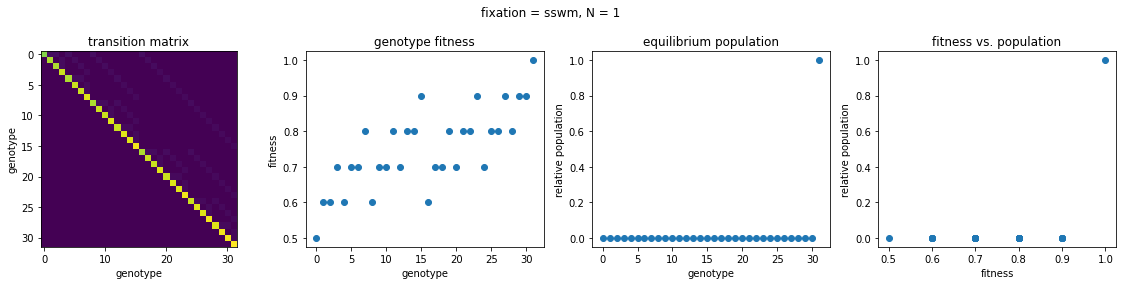

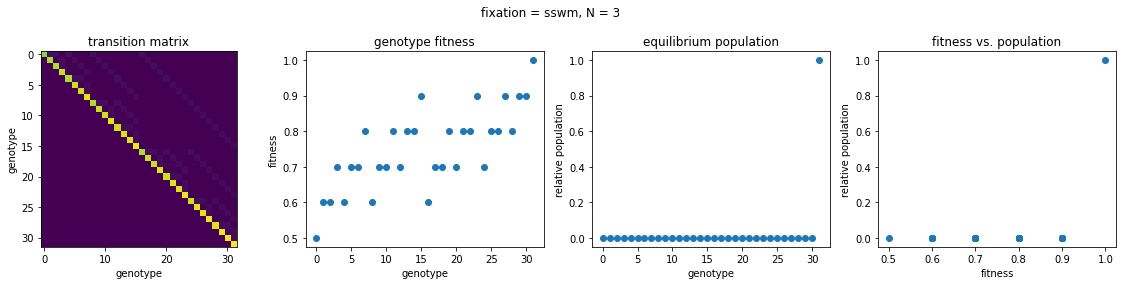

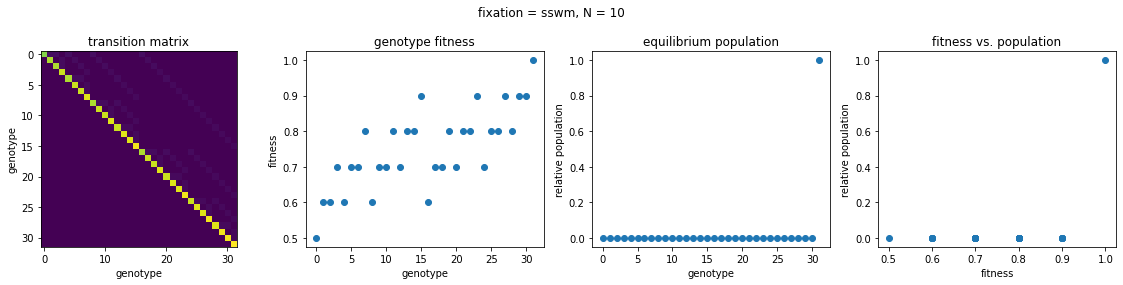

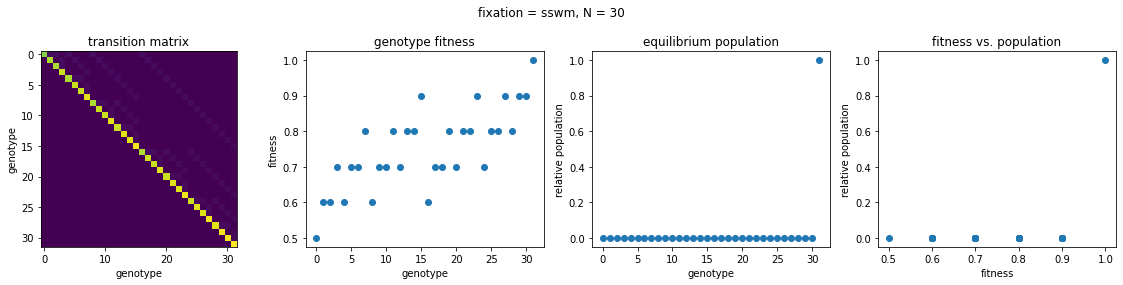

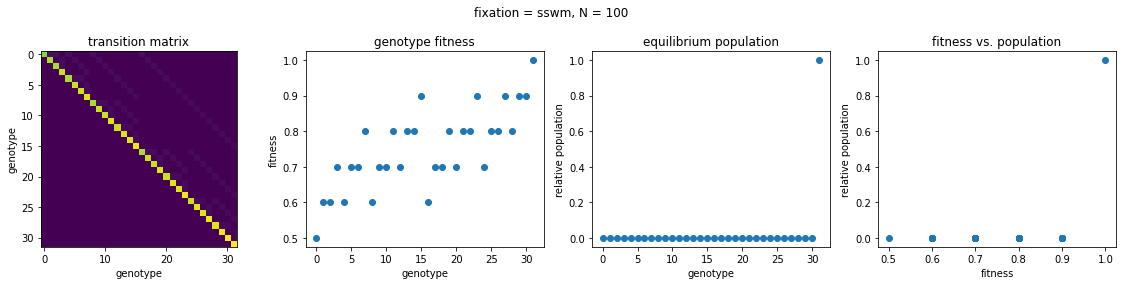

In [57]:
for N in [1,3,10,30,100]:
    T = get_and_show_T(gpm,fixation_model="sswm",population_size=N)
    plt.show()


### Simulation code

Run a Wright-Fisher simulation (haploid) starting with 1000 individuals at the lowest fitness genotype in the map. Use a mutation probability of 0.001/replication event (average of one mutant/generation given population size). These simulations randomly select genotypes that reproduce, so will give different outcomes every time. 

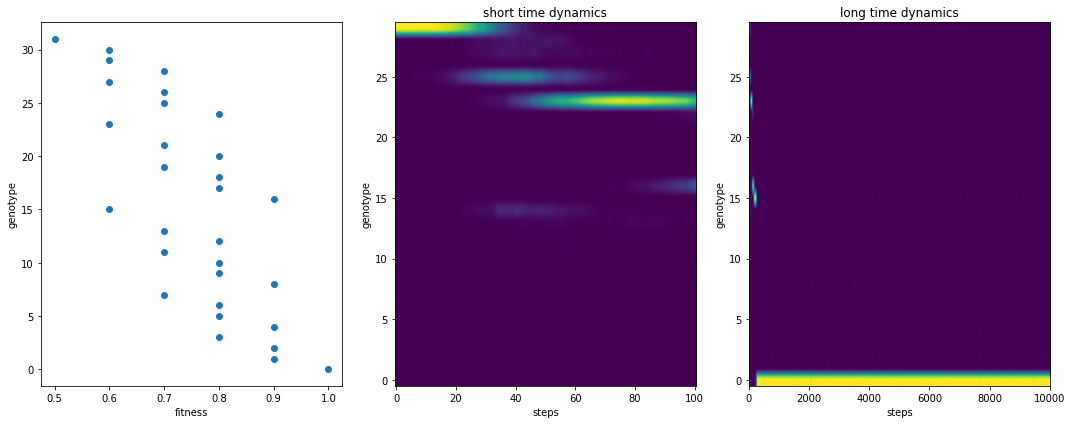

In [50]:
# Put 1000 individuals at lowest fitness genotype
minimum = gpm.data.iloc[np.argmin(gpm.data.fitness),:].name
gpm.data.loc[:,"initial_pop"] = np.zeros(len(gpm.data),dtype=int) 
gpm.data.loc[minimum,"initial_pop"] = 1000

# Simulate with mutation rate 0.001 (average of one mut/generation with pop size of 1000)
pops = gpvolve.simulate.simulate(gpm,initial_pop_column="initial_pop",mutation_rate=0.001,num_steps=10000)

# Plot only genotypes populated over the simulation
populated = np.sum(pops,axis=0) > 0
pops2 = pops[:,populated]

# Plot results
fig, ax = plt.subplots(1,3,figsize=(15,6))
ax[0].plot(gpm.fitness[populated],np.arange(len(gpm.data.fitness),dtype=int)[populated],"o")
ax[0].set_xlabel("fitness")
ax[0].set_ylabel("genotype")
ax[2].set_title("genotype fitness")
ax[1].imshow(pops2.T[:,:101],aspect="auto",origin="lower")
ax[1].set_ylabel("genotype")
ax[1].set_xlabel("steps")
ax[1].set_title("short time dynamics")
ax[2].imshow(pops2.T[:,:],aspect="auto",origin="lower")
ax[2].set_ylabel("genotype")
ax[2].set_xlabel("steps")
ax[2].set_title("long time dynamics")

fig.tight_layout()
plt.show()

